## Figure 1: characteristics of change
A set of maps and time series where you show a four panel figure: 
* mean krill growth potential
* change in krill growth potential in 2100 
* the time series for the southern ocean as a whole 
* the time series for a region. 


In [1]:
%matplotlib inline
import os
import shutil

from itertools import product
import xpersist as xp
from glob import glob

import numpy as np
import xarray as xr

import pop_tools
import intake

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean

import util

In [2]:
ds_djf_epoch = xr.open_zarr('data/cesm-le-fields-djf-epoch-mean-recent.zarr')
#ds_djf_epoch = xr.open_zarr('data/cesm-le-fields-djf-epoch-mean-6090.zarr')
ds_djf_epoch

<xarray.Dataset>
Dimensions:    (epoch: 2, length: 3, member_id: 34, nlat: 93, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    dz         (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
  * epoch      (epoch) <U9 '1985-2005' '2070-2100'
  * length     (length) float64 20.0 40.0 60.0
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * z_t        (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
  * z_t_150m   (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf   (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    IFRAC      (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    KGP        (epoch, length, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 17, 47, 160), meta=np.ndarray>
    SST        (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>

In [3]:
#Epoch Diff
with xr.set_options(keep_attrs=True):  
    ds_djf_epoch_diff = ds_djf_epoch.diff('epoch').squeeze('epoch')
ds_djf_epoch_diff

<xarray.Dataset>
Dimensions:    (length: 3, member_id: 34, nlat: 93, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    dz         (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    epoch      <U9 '2070-2100'
  * length     (length) float64 20.0 40.0 60.0
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * z_t        (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
  * z_t_150m   (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf   (member_id, nlat, nlon) float64 dask.array<chunksize=(9, 47, 160), meta=np.ndarray>
    IFRAC      (member_id, nlat, nlon) float64 dask.array<chunksize=(9, 47, 160), meta=np.ndarray>
    KGP        (length, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 17, 47, 160), meta=np.ndarray>
    SST        (member_id, nlat, nlon) float64 dask.array<chunksize=(9, 47, 160), meta=np.ndarray>

In [4]:
#What do we want to plot?

kgp_mean = ds_djf_epoch['KGP'].where(ds_djf_epoch.KMT > 0).mean('member_id')
sst_mean = ds_djf_epoch['SST'].where(ds_djf_epoch.KMT > 0).mean('member_id')
chl_mean = ds_djf_epoch['Chl_surf'].where(ds_djf_epoch.KMT > 0).mean('member_id')
ice_mean = ds_djf_epoch['IFRAC'].where(ds_djf_epoch.KMT > 0).mean('member_id')

#kgp_early = kgp_mean.sel(epoch='1960-1990', length='40')
kgp_early = kgp_mean.sel(epoch='1985-2005', length='40')

kgp_late = kgp_mean.sel(epoch='2070-2100', length='40')

kgp_diff = ds_djf_epoch_diff['KGP'].where(ds_djf_epoch_diff.KMT > 0).sel(length='40').mean('member_id')


# Lat Lon Checks
lon = ds_djf_epoch.TLONG.values
lat = ds_djf_epoch.TLAT.values

In [5]:
#Plottable

dsp = util.pop_add_cyclic(
    xr.Dataset({
        'test': kgp_early,
        'TLAT': kgp_early.TLAT.compute(),
        'TLONG': kgp_early.TLONG.compute()
    } ))


dsp2 = util.pop_add_cyclic(
    xr.Dataset({
        'test': kgp_diff,
        'TLAT': kgp_diff.TLAT.compute(),
        'TLONG': kgp_diff.TLONG.compute()
    } ))


dsp3 = util.pop_add_cyclic(
    xr.Dataset({
        'test': kgp_late,
        'TLAT': kgp_late.TLAT.compute(),
        'TLONG': kgp_late.TLONG.compute()
    } ))


## Set up for Plots

In [6]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
#levels = np.arange(-100, 45, 5) (-.5,1,6)
norm = MidpointNormalize(midpoint=0.)

extent = ([-180, 180, -90, -50], ccrs.PlateCarree()) #[120, 260, 10, 65]

prj = ccrs.SouthPolarStereo()

In [9]:
def one_plot(da, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG,
                     dsp.TLAT,
                     da,
                     #=levels=levels,
                     norm=norm,
                     #cmap=cmocean.cm.curl_r,
                     #cmap=cmocean.cm.balance,
                     cmap=cmocean.cm.diff,
                     #extend='both',
                     transform=ccrs.PlateCarree())

    # contour lines
    cs = ax.contour(dsp.TLONG,
                    dsp.TLAT,
                    da,
                    colors='k',
                    #levels=levels,
                    linewidths=0.5,
                    transform=ccrs.PlateCarree())

    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%r')

    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical',
                                            'land',
                                            '110m',
                                            facecolor='darkgray'))

    ax.coastlines(linewidth=0.5)

    return cf


/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'Growth Potential (mm day$^{-1}$)')

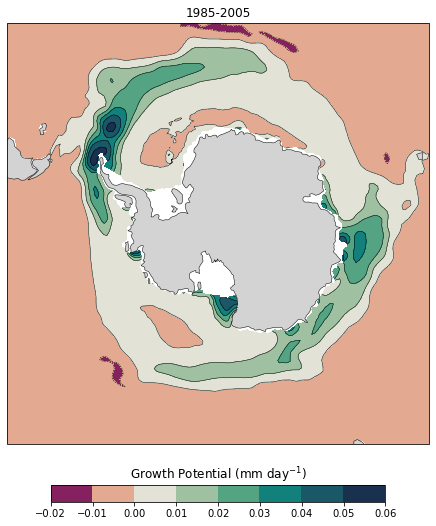

In [15]:
fig = plt.figure(figsize=(12, 10))

axs = []

# plot total
ax = fig.add_subplot(1, 1, 1, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = one_plot(dsp.test,lines = False)
ax.set_title('1985-2005')
axs.append(ax)

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal', pad=0.075, ax=axs)
cb.ax.set_title('Growth Potential (mm day$^{-1}$)')
#plt.savefig('figures/1985-2005-mean-KGP.png')#, dpi=300, bbox_inches='tight')

# add colorbar
#plt.subplots_adjust(hspace=0.02, wspace=0.02)


/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


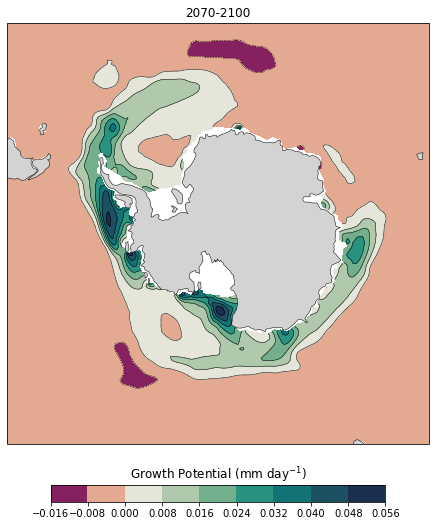

In [24]:
fig = plt.figure(figsize=(12, 10))

axs = []

# plot total
ax = fig.add_subplot(1, 1, 1, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = one_plot(dsp3.test,lines = False)
ax.set_title('2070-2100')
axs.append(ax)

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal', pad=0.075, ax=axs)
cb.ax.set_title('Growth Potential (mm day$^{-1}$)')
plt.savefig('figures/epochs/2070-2100-mean-KGP.png')#, dpi=300, bbox_inches='tight')

# add colorbar
#plt.subplots_adjust(hspace=0.02, wspace=0.02)


/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


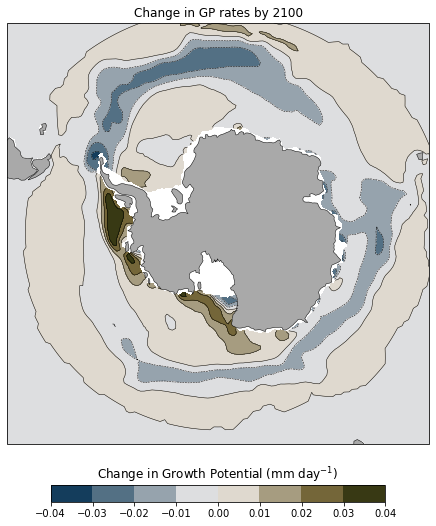

In [10]:
fig = plt.figure(figsize=(12, 10))

axs = []

# plot total
ax = fig.add_subplot(1, 1, 1, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = one_plot(dsp2.test,lines = False)
ax.set_title('Change in GP rates by 2100')
axs.append(ax)

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal', pad=0.075, ax=axs)
cb.ax.set_title('Change in Growth Potential (mm day$^{-1}$)')
plt.savefig('figures/epochs/85-70-epochdiff-mean-KGP-diff-dark.png')#, dpi=300, bbox_inches='tight')

# add colorbar
#plt.subplots_adjust(hspace=0.02, wspace=0.02)
